# HeapHop30. (2019, April 18). Graph attention nets. Retrieved from https://github.com/HeapHop30/graph-attention-nets

In [ ]:
%load_ext autoreload
%autoreload 1

In [ ]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [1]:
import os,sys,inspect
import os
import joblib
import tensorflow as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, Flatten, Activation, Dropout, LeakyReLU, MaxPooling2D, Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

import scipy.io as sio

In [2]:
import graph
import coarsening
import utils

In [3]:
# Graphs.
number_edges = 8
metric ='euclidean'
normalized_laplacian = True
coarsening_levels = 4
len_img = 28

np.random.seed(0)

In [4]:
# Useful functions

def grid_graph(m):
  z = graph.grid(m)  # normalized nodes coordinates
  dist, idx = graph.distance_sklearn_metrics(z, k=number_edges, metric=metric) 
  #dist contains the distance of the 8 nearest neighbors for each node indicated in z sorted in ascending order
  #idx contains the indexes of the 8 nearest for each node sorted in ascending order by distance

  A = graph.adjacency(dist, idx)  # graph.adjacency() builds a sparse matrix out of the identified edges computing similarities as: A_{ij} = e^(-dist_{ij}^2/sigma^2)

  return A, z

  
def plot_matrix(m):
  plt.figure(figsize = (10, 10))
  plt.imshow(m.toarray())
  plt.show


# A friend helped me a lot with this function, so you will find something similar in other assignment
def coarsen_mnist(A, levels, nodes_coordinates):
    graphs, parents = coarsening.metis(A, levels) #Coarsen a graph multiple times using Graclus variation of the METIS algorithm. 
                                                  #Basically, we randomly sort the nodes, we iterate on them and we decided to group each node
                                                  #with the neighbor having highest w_ij * 1/(\sum_k w_ik) + w_ij * 1/(\sum_k w_kj) 
                                                  #i.e. highest sum of probabilities to randomly walk from i to j and from j to i.
                                                  #We thus favour strong connections (i.e. the ones with high weight wrt all the others for both nodes) 
                                                  #in the choice of the neighbor of each node.
                    
                                                  #Construction is done a priori, so we have one graph for all the samples!
                    
                                                  #graphs = list of spare adjacency matrices (it contains in position 
                                                  #          0 the original graph)
                                                  #parents = list of numpy arrays (every array in position i contains 
                                                  #           the mapping from graph i to graph i+1, i.e. the idx of
                                                  #           node i in the coarsed graph -> that is, the idx of its cluster) 
    perms = coarsening.compute_perm(parents) #Return a list of indices to reorder the adjacency and data matrices so
                                             #that two consecutive nodes correspond to neighbors that should be collapsed
                                             #to produce the coarsed version of the graph.
                                             #Fake nodes are appended for each node which is not grouped with anybody else
    
    coordinates = np.copy(nodes_coordinates)
    u_shape, u_rows, u_cols, u_val = [], [], [], []
    
    for i,A in enumerate(graphs):
        M, M = A.shape

        # We remove self-connections created by metis.
        A = A.tocoo()
        A.setdiag(0)

        if i < levels: #if we have to pool the graph 
            A = coarsening.perm_adjacency(A, perms[i]) #matrix A is here extended with the fakes nodes
                                                       #in order to do an efficient pooling operation
                                                       #in tensorflow as it was a 1D pooling

        A = A.tocsr()
        A.eliminate_zeros()
        
        Mnew, Mnew = A.shape
        u_shape.append(Mnew)
        
        if i == 0:
            fake_nodes = Mnew - M
            coordinates = np.concatenate([coordinates, np.ones([fake_nodes, 2])*np.inf], 0)
            coordinates = coordinates[perms[0]]
        
        start_node, end_node = A.nonzero()
        u_rows.append(start_node)
        u_cols.append(end_node)
        
        distance = coordinates[start_node] - coordinates[end_node]
        u_val.append(distance)
        
        print('Layer {0}: M_{0} = |V| = {1} nodes ({2} added), |E| = {3} edges'.format(i, Mnew, Mnew-M, A.nnz//2))
        
        # update coordinates for next coarser graph
        new_coordinates = []
        for k in range(A.shape[0]//2):
            idx_first_el = k * 2
            
            if not np.isfinite(coordinates[idx_first_el][0]):
                new_coordinates.append(coordinates[idx_first_el+1])
                
            elif not np.isfinite(coordinates[idx_first_el+1][0]):
                new_coordinates.append(coordinates[idx_first_el])
                
            else:
                new_coordinates.append(np.mean(coordinates[idx_first_el:idx_first_el+2], axis=0))
                
        coordinates = np.asarray(new_coordinates)

    return u_shape, u_rows, u_cols, u_val, perms[0]


In [5]:
# Load fashion_MNIST dataset

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
y_train = y_train.astype(np.float32) 
y_test = y_test.astype(np.float32)

val_n = len(x_train)//100 * 15
(x_val, y_val) = x_train[0:val_n], y_train[0:val_n]
(x_train, y_train) = x_train[val_n:], y_train[val_n:]
x_val = x_val.astype(np.float32)
y_val = y_val.astype(np.float32)

x_train_original = x_train.reshape(-1, len_img*len_img)
x_val_original = x_val.reshape(-1, len_img*len_img)
x_test_original = x_test.reshape(-1, len_img*len_img)

print(x_train_original.shape)

(51000, 784)


In [6]:
# Create u

n_rows_cols = 28
A, nodes_coordinates = grid_graph(n_rows_cols)
u_shape, u_rows, u_cols, u_val, perm = coarsen_mnist(A, coarsening_levels, nodes_coordinates)

u = []
for level in range(coarsening_levels):
    u.append([u_shape[level], u_rows[level], u_cols[level], u_val[level]])

Layer 0: M_0 = |V| = 1024 nodes (240 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 512 nodes (103 added), |E| = 1448 edges
Layer 2: M_2 = |V| = 256 nodes (38 added), |E| = 691 edges
Layer 3: M_3 = |V| = 128 nodes (10 added), |E| = 347 edges
Layer 4: M_4 = |V| = 64 nodes (0 added), |E| = 171 edges


In [7]:
# Coarsen dataset

x_train = coarsening.perm_data(x_train_original, perm)
x_val = coarsening.perm_data(x_val_original, perm)
x_test = coarsening.perm_data(x_test_original, perm)

x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape)

(51000, 1024, 1)


In [8]:
# Create Gaussian weightning 

class Weighting(Layer):

  def __init__(self, u, d, batch_size, **kwargs):
    self.u = u
    self.d = d
    self.batch_size = batch_size
    super(Weighting, self).__init__(**kwargs)

  def build(self, input_shape):
    self.mu = self.add_weight(name='mu',
                              shape=(1, self.d),
                              initializer='uniform',
                              trainable=True)
    self.sigma = self.add_weight(name='sigma',
                                 shape=(1, self.d),
                                 initializer='uniform',
                                 trainable=True)
    super(Weighting, self).build(input_shape)  

  def call(self, X):
    batch_size, n_nodes, n_features = X.shape
    batch_size = self.batch_size
    u_shape, u_rows, u_cols, u_val = self.u

    diff =  tf.square(u_val - self.mu)
    factor = tf.square(self.sigma) + 1e-14
    weights = -0.5 * (diff / factor)
    weights = tf.math.reduce_sum(weights, axis=1)

    weights = tf.SparseTensor(indices=np.vstack([u_rows, u_cols]).T, 
                              values=weights, 
                              dense_shape=[u_shape]*2)
    weights = tf.sparse.reorder(weights)
    weights = tf.sparse.softmax(weights)
    
    X_t = tf.reshape(tf.transpose(X, [1,2,0]), [n_nodes, batch_size * n_features])
    
    D = tf.sparse.sparse_dense_matmul(weights, X_t)
    D = tf.transpose(tf.reshape(D, [n_nodes, n_features, batch_size]), [2,0,1])
    
    return D
    
  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

  
# Create Gaussian (kernel) layer

class MoNet(Layer):

  def __init__(self, u, d, n_gaussian, n_hidden, batch_size, **kwargs):
    self.u = u
    self.d = d
    self.n_gaussian = n_gaussian
    self.n_hidden = n_hidden
    self.batch_size = batch_size
    
    self.weightings = []
    for k in range(self.n_gaussian):
      weighting = Weighting(self.u, self.d, self.batch_size, trainable=True)
      self.weightings.append(weighting)
      
    super(MoNet, self).__init__(**kwargs)

  def build(self, input_shape):
    self.W = self.add_weight(name='W', 
                             shape=(input_shape[-1] * self.n_gaussian, self.n_hidden),
                             initializer='uniform',
                             trainable=True)

    super(MoNet, self).build(input_shape)  # Be sure to call this at the end

  def call(self, X):
    weightings = []
    for k in range(self.n_gaussian):
      weighting = self.weightings[k](X)
      weightings.append(weighting)
    
    weights = tf.transpose(tf.stack(weightings), [1,2,3,0])
    
    batch_size, n_nodes, n_features = X.shape
    batch_size = self.batch_size
    weights = tf.reshape(weights, [batch_size*n_nodes, n_features*self.n_gaussian])
    
    h = weights @ self.W
    h = tf.reshape(h, [batch_size, n_nodes, self.n_hidden])

    return h

  def compute_output_shape(self, input_shape):
    return (input_shape[1], self.n_hidden)

  
class MPool1(Layer):
      def __init__(self, p, **kwargs):
         self.p = p
         super(MPool1, self).__init__(**kwargs)
     
      def call(self, X):
        """Max pooling of size p. Should be a power of 2 (this is possible thanks to the reordering we previously did)."""
        if self.p > 1:
          X = tf.expand_dims(X, 3)  # shape = N x M x F x 1
          X = tf.nn.max_pool(X, ksize=[1,self.p,1,1], strides=[1, self.p,1,1], padding='SAME')
          X = tf.squeeze(X, [3])  # shape = N x M/p x F
        return X
          
      def compute_output_shape(self, input_shape):
        return input_shape# Create Gaussian weightning 

class Weighting(Layer):

  def __init__(self, u, d, batch_size, **kwargs):
    self.u = u
    self.d = d
    self.batch_size = batch_size
    super(Weighting, self).__init__(**kwargs)

  def build(self, input_shape):
    self.mu = self.add_weight(name='mu',
                              shape=(1, self.d),
                              initializer='uniform',
                              trainable=True)
    self.sigma = self.add_weight(name='sigma',
                                 shape=(1, self.d),
                                 initializer='uniform',
                                 trainable=True)
    super(Weighting, self).build(input_shape)  

  def call(self, X):
    batch_size, n_nodes, n_features = X.shape
    batch_size = self.batch_size
    u_shape, u_rows, u_cols, u_val = self.u

    diff =  tf.square(u_val - self.mu)
    factor = tf.square(self.sigma) + 1e-14
    weights = -0.5 * (diff / factor)
    weights = tf.math.reduce_sum(weights, axis=1)

    weights = tf.SparseTensor(indices=np.vstack([u_rows, u_cols]).T, 
                              values=weights, 
                              dense_shape=[u_shape]*2)
    weights = tf.sparse.reorder(weights)
    weights = tf.sparse.softmax(weights)
    
    X_t = tf.reshape(tf.transpose(X, [1,2,0]), [n_nodes, batch_size * n_features])
    
    D = tf.sparse.sparse_dense_matmul(weights, X_t)
    D = tf.transpose(tf.reshape(D, [n_nodes, n_features, batch_size]), [2,0,1])
    
    return D
    
  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

  
# Create Gaussian (kernel) layer

class MoNet(Layer):

  def __init__(self, u, d, n_gaussian, n_hidden, batch_size, **kwargs):
    self.u = u
    self.d = d
    self.n_gaussian = n_gaussian
    self.n_hidden = n_hidden
    self.batch_size = batch_size
    
    self.weightings = []
    for k in range(self.n_gaussian):
      weighting = Weighting(self.u, self.d, self.batch_size, trainable=True)
      self.weightings.append(weighting)
      
    super(MoNet, self).__init__(**kwargs)

  def build(self, input_shape):
    self.W = self.add_weight(name='W', 
                             shape=(input_shape[-1] * self.n_gaussian, self.n_hidden),
                             initializer='uniform',
                             trainable=True)

    super(MoNet, self).build(input_shape)  # Be sure to call this at the end

  def call(self, X):
    weightings = []
    for k in range(self.n_gaussian):
      weighting = self.weightings[k](X)
      weightings.append(weighting)
    
    weights = tf.transpose(tf.stack(weightings), [1,2,3,0])
    
    batch_size, n_nodes, n_features = X.shape
    batch_size = self.batch_size
    weights = tf.reshape(weights, [batch_size*n_nodes, n_features*self.n_gaussian])
    
    h = weights @ self.W
    h = tf.reshape(h, [batch_size, n_nodes, self.n_hidden])

    return h

  def compute_output_shape(self, input_shape):
    return (input_shape[1], self.n_hidden)

  
class MPool1(Layer):
      def __init__(self, p, **kwargs):
         self.p = p
         super(MPool1, self).__init__(**kwargs)
     
      def call(self, X):
        """Max pooling of size p. Should be a power of 2 (this is possible thanks to the reordering we previously did)."""
        if self.p > 1:
          X = tf.expand_dims(X, 3)  # shape = N x M x F x 1
          X = tf.nn.max_pool(X, ksize=[1,self.p,1,1], strides=[1, self.p,1,1], padding='SAME')
          X = tf.squeeze(X, [3])  # shape = N x M/p x F
        return X
          
      def compute_output_shape(self, input_shape):
        return input_shape

In [13]:
# Hyperparameters

epochs=10
# For this implementation, batch_size needs to be a divisor of the number of samples (x_train = 51000 samples)
batch_size = 10
d = 2
n_classes=10
n_gaussian = 25

dropout = 0.5
learning_rate = 1e-4
reg = l2(5e-4)
momentum = 0.8
p = 4

# Model with MoNet

In [14]:
# Build the model

model = Sequential()
model.add(MoNet(u=u[0], d=d, n_gaussian=n_gaussian, n_hidden=32, batch_size=batch_size, trainable=True))
model.add(MPool1(p=p))
model.add(tf.keras.layers.Dropout(0.25))
model.add(MoNet(u=u[2], d=d, n_gaussian=n_gaussian, n_hidden=64, batch_size=batch_size, trainable=True))
model.add(MPool1(p=p))
model.add(tf.keras.layers.Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=reg))
model.add(Dropout(dropout))
model.add(Dense(n_classes, activation='softmax', kernel_regularizer=reg))

model.compile(optimizer=tf.optimizers.RMSprop(learning_rate=learning_rate, momentum=momentum),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((51000, 1024, 1), (51000,), (9000, 1024, 1), (9000,))

In [16]:
# Train the model

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size)

Epoch 1/10
5100/5100 [==============================] - 375s 73ms/step - loss: 0.7032 - accuracy: 0.8205 - val_loss: 0.5332 - val_accuracy: 0.8661
Epoch 2/10
5100/5100 [==============================] - 365s 72ms/step - loss: 0.5931 - accuracy: 0.8531 - val_loss: 0.5644 - val_accuracy: 0.8539
Epoch 3/10
5100/5100 [==============================] - 545s 107ms/step - loss: 0.5884 - accuracy: 0.8586 - val_loss: 0.4935 - val_accuracy: 0.8901
Epoch 4/10
5100/5100 [==============================] - 548s 107ms/step - loss: 0.5889 - accuracy: 0.8621 - val_loss: 0.5174 - val_accuracy: 0.8821
Epoch 5/10
5100/5100 [==============================] - 525s 103ms/step - loss: 0.5907 - accuracy: 0.8631 - val_loss: 0.5227 - val_accuracy: 0.8879
Epoch 6/10
5100/5100 [==============================] - 411s 81ms/step - loss: 0.5904 - accuracy: 0.8661 - val_loss: 0.5388 - val_accuracy: 0.8762
Epoch 7/10
5100/5100 [==============================] - 385s 75ms/step - loss: 0.5933 - accuracy: 0.8671 - val_loss

In [17]:
model.evaluate(x_test, y_test, batch_size=batch_size)

1000/1000 [==============================] - 21s 21ms/step - loss: 0.5469 - accuracy: 0.8803


[0.5468612313270569, 0.880299985408783]

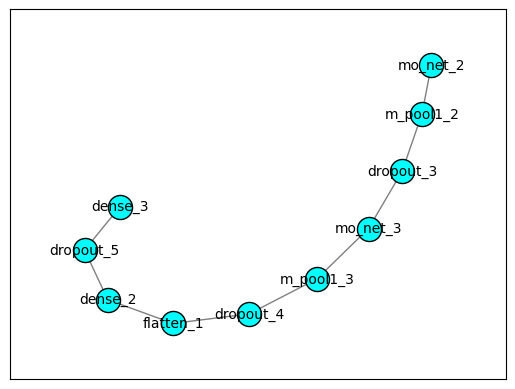

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add input layer separately
input_layer = model.layers[0]
G.add_node(input_layer.name)

# Add the remaining layers
for layer in model.layers[1:]:
    G.add_node(layer.name)

# Add edges between layers
for layer in model.layers[1:]:
    inbound_layers = layer._inbound_nodes[0].inbound_layers
    if isinstance(inbound_layers, list):
        for inbound_layer in inbound_layers:
            G.add_edge(inbound_layer.name, layer.name)
    else:
        G.add_edge(inbound_layers.name, layer.name)

# Customize node and edge colors
node_color = 'aqua'
edge_color = 'gray'

# Set node positions using a spring layout
pos = nx.spring_layout(G)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_color, edgecolors='black')
nx.draw_networkx_edges(G, pos, edge_color=edge_color)

# Add node labels
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10)

# Adjust plot margins
ax = plt.gca()
ax.margins(0.15)

# Remove axis ticks
plt.xticks([])
plt.yticks([])

# Show the plot
plt.show()


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mo_net_2 (MoNet)            (10, 1024, 32)            900       
                                                                 
 m_pool1_2 (MPool1)          (10, 256, 32)             0         
                                                                 
 dropout_3 (Dropout)         (10, 256, 32)             0         
                                                                 
 mo_net_3 (MoNet)            (10, 256, 64)             51300     
                                                                 
 m_pool1_3 (MPool1)          (10, 64, 64)              0         
                                                                 
 dropout_4 (Dropout)         (10, 64, 64)              0         
                                                                 
 flatten_1 (Flatten)         (10, 4096)               

# Model 2

In [30]:
# Hyperparameters

epochs=10
# For this implementation, batch_size needs to be a divisor of the number of samples (x_train = 51000 samples)
batch_size = 10
d = 2
n_classes=10
n_gaussian = 25

dropout = 0.5
learning_rate = 1e-5
reg = l2(1e-4)
momentum = 0.8
p = 4

In [51]:
# Build the model

model = Sequential()
model.add(MoNet(u=u[0], d=d, n_gaussian=n_gaussian, n_hidden=32, batch_size=batch_size, trainable=True))
model.add(MPool1(p=p))
model.add(tf.keras.layers.Dropout(0.25))
model.add(MoNet(u=u[2], d=d, n_gaussian=n_gaussian, n_hidden=64, batch_size=batch_size, trainable=True))
model.add(MPool1(p=p))
model.add(tf.keras.layers.Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=reg))
model.add(Dropout(dropout))
model.add(Dense(n_classes, activation='softmax', kernel_regularizer=reg))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [52]:
# Train the model

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size)

Epoch 1/10
5100/5100 [==============================] - 344s 67ms/step - loss: 0.7026 - accuracy: 0.8126 - val_loss: 0.6248 - val_accuracy: 0.8561
Epoch 2/10
5100/5100 [==============================] - 353s 69ms/step - loss: 0.6884 - accuracy: 0.8397 - val_loss: 0.5948 - val_accuracy: 0.8771
Epoch 3/10
5100/5100 [==============================] - 357s 70ms/step - loss: 0.6783 - accuracy: 0.8477 - val_loss: 0.6059 - val_accuracy: 0.8722
Epoch 4/10
5100/5100 [==============================] - 352s 69ms/step - loss: 0.6703 - accuracy: 0.8492 - val_loss: 0.5824 - val_accuracy: 0.8824
Epoch 5/10
5100/5100 [==============================] - 347s 68ms/step - loss: 0.6679 - accuracy: 0.8520 - val_loss: 0.5610 - val_accuracy: 0.8863
Epoch 6/10
5100/5100 [==============================] - 350s 69ms/step - loss: 0.6570 - accuracy: 0.8527 - val_loss: 0.5720 - val_accuracy: 0.8816
Epoch 7/10
5100/5100 [==============================] - 355s 70ms/step - loss: 0.6473 - accuracy: 0.8551 - val_loss: 0

In [53]:
model.evaluate(x_test, y_test, batch_size=batch_size)

1000/1000 [==============================] - 20s 20ms/step - loss: 0.5812 - accuracy: 0.8753


[0.5812488198280334, 0.8752999901771545]

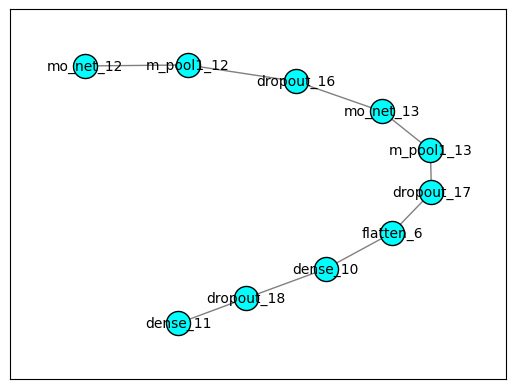

In [47]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add input layer separately
input_layer = model.layers[0]
G.add_node(input_layer.name)

# Add the remaining layers
for layer in model.layers[1:]:
    G.add_node(layer.name)

# Add edges between layers
for layer in model.layers[1:]:
    inbound_layers = layer._inbound_nodes[0].inbound_layers
    if isinstance(inbound_layers, list):
        for inbound_layer in inbound_layers:
            G.add_edge(inbound_layer.name, layer.name)
    else:
        G.add_edge(inbound_layers.name, layer.name)

# Customize node and edge colors
node_color = 'aqua'
edge_color = 'gray'

# Set node positions using a spring layout
pos = nx.spring_layout(G)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_color, edgecolors='black')
nx.draw_networkx_edges(G, pos, edge_color=edge_color)

# Add node labels
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=10)

# Adjust plot margins
ax = plt.gca()
ax.margins(0.15)

# Remove axis ticks
plt.xticks([])
plt.yticks([])

# Show the plot
plt.show()


In [54]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mo_net_14 (MoNet)           (10, 1024, 32)            900       
                                                                 
 m_pool1_14 (MPool1)         (10, 256, 32)             0         
                                                                 
 dropout_19 (Dropout)        (10, 256, 32)             0         
                                                                 
 mo_net_15 (MoNet)           (10, 256, 64)             51300     
                                                                 
 m_pool1_15 (MPool1)         (10, 64, 64)              0         
                                                                 
 dropout_20 (Dropout)        (10, 64, 64)              0         
                                                                 
 flatten_7 (Flatten)         (10, 4096)               